### **Importing libraries**

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from keras.models import Sequential, load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
import cv2

### **Drive Files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/fer2013.csv.zip

Archive:  drive/MyDrive/fer2013.csv.zip
  inflating: fer2013.csv             


### **Loading the dataset**

In [ ]:
emotion_data = pd.read_csv('/content/fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


### **Dividing Test and Train data**

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in emotion_data.iterrows():
    k = list(map(int, row['pixels'].split(" ")))
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

y_train= np_utils.to_categorical(y_train, num_classes=7)
y_test = np_utils.to_categorical(y_test, num_classes=7)

In [ ]:
model = Sequential()

#1st Convolutional layer
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

#2nd Convolutional layer
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(2,2)))

#3rd Convolutional layer
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((1,1), strides=(2,2)))

#4th Convolutional layer
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((1,1), strides=(2,2)))


model.add(Flatten())

#Fu
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

AttributeError: ignored

In [ ]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train,y_train,batch_size=32,epochs=5,verbose=1,validation_data=(X_test, y_test))

Epoch 1/5
898/898 [==============================] - 52s 58ms/step - loss: 1.8200 - accuracy: 0.2513 - val_loss: 1.8138 - val_accuracy: 0.2494
Epoch 2/5
898/898 [==============================] - 51s 57ms/step - loss: 1.8114 - accuracy: 0.2513 - val_loss: 1.8128 - val_accuracy: 0.2494
Epoch 3/5
898/898 [==============================] - 52s 58ms/step - loss: 1.8107 - accuracy: 0.2513 - val_loss: 1.8128 - val_accuracy: 0.2494
Epoch 4/5
898/898 [==============================] - 52s 57ms/step - loss: 1.8103 - accuracy: 0.2513 - val_loss: 1.8109 - val_accuracy: 0.2494
Epoch 5/5
898/898 [==============================] - 51s 57ms/step - loss: 1.8104 - accuracy: 0.2513 - val_loss: 1.8110 - val_accuracy: 0.2494


In [ ]:
loss_and_metrics = model.evaluate(X_test,y_test)
print(loss_and_metrics)

113/113 [==============================] - 2s 17ms/step - loss: 1.8110 - accuracy: 0.2494
[1.8110069036483765, 0.24937307834625244]


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

In [ ]:
cap=cv2.VideoCapture(0)

while cap.isOpened():
    _, test_image=cap.read()
    print(type(test_image))
    print(test_image)
    coverted_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)


    faces_detected = face_haar_cascade.detectMultiScale(converted_image)
    for (x,y,w,h) in faces_detected:
      cv2.rectangle(test_image,(x,y), (x+w,y+h), (255,0,0))
      roi_gray=gray_image[y:y+w,x:x+h]
      roi_gray=cv2.resize(roi_gray,(48,48))
      image_pixels = image.image_to_array(roi_gray)
      image_pixels = np.expand_dims(image_pixels, axis = 0)
      image_pixels /= 255


      predictions = model.predict(image_pixels)
      max_index = np.argmax(predictions[0])

      emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
      emotion_prediction = emotion_detection[max_index]


      
      cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)  
      # cv2.putText(image,"Hello World!!!", (x,y), 0, 2, 255)

cv2.putText(test_image, emotion_prediction, (int(x), int(y)))
      resized_image = cv2.resize(image, (1000, 700))
      cv2.imshow('Emotion',resized_image)
      if cv2.waitKey(10) == ord('b'):
        break
if cap.isOpened!='True':
  print("heyyy")

cap.release()
cv2.destroyAllWindows()

heyyy


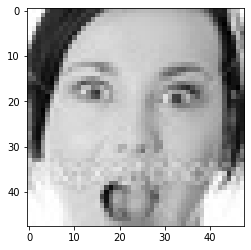

In [ ]:
face_image  = cv2.imread("/336.jpg")
plt.imshow(face_image)

In [ ]:
print(face_image.shape)

(48, 48, 3)


In [ ]:
model = load_model("/content/drive/MyDrive/model.h5")
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

In [ ]:
face_image = cv2.resize(face_image, (48,48))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])

In [ ]:
print(face_image.shape)

(1, 48, 48, 1)


In [ ]:
predicted_class = np.argmax(model.predict(face_image))

In [ ]:
label_map = dict((v,k) for k,v in emotion_dict.items()) 
predicted_label = label_map[predicted_class]

In [ ]:
print(predicted_label)

Surprise
